In [ ]:

#----------------------------------------------
#             MOUNT GOOGLE DRIVE    
#----------------------------------------------  
from google.colab import drive
drive.mount('/content/drive')

#----------------------------------------------
#           PRINT FILES IN DIRECTORY 
#----------------------------------------------
!ls "/content/drive/My Drive"
!pwd

# **`data_handler.py`**


---



In [15]:
# import all libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
''' 
@author: Mpountou
@year: 2020
'''
 
class data_handler:
  """
    A class to handle and preprocess data before make recommendation
    ...
    
    Attributes
    ----------
    path : str
       location directory file of data 
    columns : array
       array of columns that should keep from data 
    
    Methods
    -------
    loadDataFrame()
       retruns dataframe based on path and columns
    deep_preprocessing()
       returns dataframe for deep learning model based, total users, total items and minmax of ratings
    split()
       splits the data given the user input 
    create_matrix()
       creates a user - item matrix given the user item dataframe 
  
    """ 
  def __init__(self,path,columns):
    # make path global
    self.path = path
    # make cols global
    self.columns = columns

  def loadDataFrame(self):
    # generate dataframe - user,item,rating
    dataset = pd.read_pickle(self.path)

    # return data with declared columns
    return dataset[self.columns]

  def deep_preprocessing(self,dataset):
    # init encoder
    encoder = LabelEncoder()
    # create new data frame for deep learning model
    df = pd.DataFrame(columns=dataset.columns)
    # user encode
    df[columns[0]] = encoder.fit_transform(dataset[columns[0]].values)
    # get num of total users
    t_users = df[columns[0]].nunique()
    # init encoder
    itemencoder = LabelEncoder()
    # item encode
    df[columns[1]] = itemencoder.fit_transform(dataset[columns[1]].values)
    # get num of total items
    t_items = df[columns[1]].nunique()
    # typecast rating to float
    df[columns[2]] = dataset[columns[2]].values.astype(np.float32)
    # find min and max of ratings
    minmax = (min(df[columns[2]]),max(df[columns[2]]))

    # return dataframe,total users, total items, and min-max of ratings
    return df,t_users,t_items,minmax,itemencoder,encoder

  def split(self,df,input_user,test_size):
    # get ratings of input user
    input_user_data = df.loc[df[self.columns[0]] == input_user]
    # split ratings to test and train
    train_X, test_X, train_y, test_y = train_test_split(input_user_data, input_user_data.index.tolist(), test_size=test_size, random_state=1)
    # copy all data
    tmp_dataset = df.copy()
    # remove test data
    tmp_dataset.loc[test_X.index.tolist(),self.columns[2]] = -1
    # keep all data except of test data 
    tmp_dataset = tmp_dataset.loc[tmp_dataset[self.columns[2]] >=0]
    # declare train data
    train_X = tmp_dataset
    
    # return train and test data
    return train_X,test_X

  def rec_split(self,df):
    train_X, test_X, train_y, test_y = train_test_split(df, df.index.tolist(), test_size=0.01, random_state=1)
     # return train and test data
    return train_X,test_X

  def create_matrix(dataset,columns,fill_unrated_with):
    # unique value of every user
    users = dataset[columns[0]].unique()
    # number of total users
    t_users = len(users)
    # unique value of every items
    items = dataset[columns[1]].unique()
    items.sort()
    # number of total items
    t_items = len(items)
    # initialize data with zeros
    data = np.empty((t_users,t_items))
    data[:] = fill_unrated_with
    # create user - item matrix
    matrix = pd.DataFrame(data= data,columns=items)

    # fill user-item matrix with ratings
    for user in range(len(users)):
      # current user dataframe
      user_ = dataset.loc[dataset[columns[0]] == users[user]]
      # every item id that user rated
      itemID = user_[columns[1]].tolist()
      # every rating for every item that user rated
      ratingValue = user_[columns[2]].tolist()
      for j in range(len(itemID)):
        # fill ratings on user-item matrix
        matrix[itemID[j]][user] =  ratingValue[j]  

    # return user-item matrix
    return matrix
  


# **`evaluator.py`**

In [16]:
import seaborn as sns
from matplotlib import pyplot
sns.set_theme()
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt

class evaluator:

  def calculate_metrics(self,df,threshold):

    y_true = df['y_true'].tolist()
    y_pred = df['y_pred'].tolist()

    # calculate rmse
    rmse = mean_squared_error(y_true,y_pred)**(1/2)

    # calculate mae
    mae = mean_absolute_error(y_true,y_pred)   
    # convert predictions to binary based on threshold

    pred = [1 if x >=threshold else 0 for x in y_pred]
    true = [1 if x >=threshold else 0 for x in y_true]
    # calculate accuracy
    acc_ = accuracy_score(true,pred)
    # calculate recall
    rec_ = recall_score(true, pred)
    # calculate precision
    prec_ =precision_score(true, pred)
    # calculate f1 score
    f1_ = f1_score(true, pred)

    return rmse,mae,acc_,rec_,prec_,f1_

  def average_arpf_rm(self,data,cols,threshold,model):

    rmse = []
    mae = []

    acc = []  
    rec = []
    pre = []
    f1 = []

    all_users = data[cols[0]].unique()
    for i in all_users:

      u_data = data.loc[data[cols[0]] == i]

      y_pred = u_data['y_pred']
      y_test = u_data['y_true']

      labels_pred = [1 if i>=threshold else 0 for i in y_pred]
      labels_true = [1 if i>=threshold else 0 for i in y_test]

      acc.append(accuracy_score(labels_true,labels_pred))
      rec.append(recall_score(labels_true,labels_pred))
      pre.append(precision_score(labels_true,labels_pred))
      f1.append(f1_score(labels_true,labels_pred))

      rmse.append(mean_squared_error(y_test,y_pred)**(1/2))
      mae.append(mean_absolute_error(y_test,y_pred))



    df = pd.DataFrame(columns=['model','metric','score'])

    df = df.append(pd.DataFrame(data=[[model,'accuracy',np.mean(acc)]] , columns=['model','metric','score']))
    df = df.append(pd.DataFrame(data=[[model,'recall',np.mean(rec)]] , columns=['model','metric','score']))
    df = df.append(pd.DataFrame(data=[[model,'precision',np.mean(pre)]] , columns=['model','metric','score']))
    df = df.append(pd.DataFrame(data=[[model,'f1_score',np.mean(f1)]] , columns=['model','metric','score']))

    # reset index  
    df = df.reset_index().drop(columns='index')

    df2 = pd.DataFrame(columns=['model','metric','score'])

    df2 = df2.append(pd.DataFrame(data=[[model,'rmse',np.mean(rmse)]] , columns=['model','metric','score']))
    df2 = df2.append(pd.DataFrame(data=[[model,'mae',np.mean(mae)]] , columns=['model','metric','score']))

    # reset index  
    df2 = df2.reset_index().drop(columns='index')

    return df,df2

  def nei_metric_df(self,user,neigh,df,threshold):
    # calculate matrics
    rmse,mae,acc_,rec_,prec_,f1_ = self.calculate_metrics(df,threshold)
    # create a dataframe with those metrics, scores and neighbors
    df = pd.DataFrame(columns=['user','metric','score','neighbors']) 
    # append accuracy
    df = df.append(pd.DataFrame(data=[[user,'accuracy',acc_,neigh]],columns=['user','metric','score','neighbors']))
    # append recall
    df = df.append(pd.DataFrame(data=[[user,'recall',rec_,neigh]],columns=['user','metric','score','neighbors']))
    # append precision
    df = df.append(pd.DataFrame(data=[[user,'precision',prec_,neigh]],columns=['user','metric','score','neighbors']))
    # append f1_score
    df = df.append(pd.DataFrame(data=[[user,'f1_score',f1_,neigh]],columns=['user','metric','score','neighbors']))
    df2 = pd.DataFrame(columns=['user','metric','score','neighbors']) 
    # append accuracy
    df2 = df2.append(pd.DataFrame(data=[[user,'rmse',rmse,neigh]],columns=['user','metric','score','neighbors']))
    # append recall
    df2 = df2.append(pd.DataFrame(data=[[user,'mae',mae,neigh]],columns=['user','metric','score','neighbors']))
    
    return df,df2
    
  def user_metric_df(self,user,df,threshold):
    # calculate matrics
    rmse,mae,acc_,rec_,prec_,f1_ = self.calculate_metrics(df,threshold)
    # create a dataframe with those metrics and scores
    df = pd.DataFrame(columns=['user','metric','score']) 
    # append accuracy
    df = df.append(pd.DataFrame(data=[[user,'accuracy',acc_]],columns=['user','metric','score']))
    # append recall
    df = df.append(pd.DataFrame(data=[[user,'recall',rec_]],columns=['user','metric','score']))
    # append precision
    df = df.append(pd.DataFrame(data=[[user,'precision',prec_]],columns=['user','metric','score']))
    # append f1_score
    df = df.append(pd.DataFrame(data=[[user,'f1_score',f1_]],columns=['user','metric','score']))

    df2 = pd.DataFrame(columns=['user','metric','score']) 
    # append accuracy
    df2 = df2.append(pd.DataFrame(data=[[user,'rmse',rmse]],columns=['user','metric','score']))
    # append recall
    df2 = df2.append(pd.DataFrame(data=[[user,'mae',mae]],columns=['user','metric','score']))
    
    return df,df2

  def visualize_bars(self,df,axe_x,axe_y,hue,title,x_dist,hei_,asp_):
    sns.color_palette("husl", 8)
    g = sns.catplot(
    data=df, kind="bar",
    x=axe_x, y=axe_y, hue=hue,
    ci="sd", palette="dark", alpha=.6, height=hei_,legend_out = True,aspect=asp_
    ) 
    ax = g.facet_axis(0,0)
    for p in ax.patches:
        ax.text(p.get_x() + x_dist, 
                p.get_height() * 1.02, 
                '{0:.2f}'.format(p.get_height()), 
                color='black', rotation='horizontal', size='large')
    g.despine(left=True)
    g.set_axis_labels("", "Percent (%)")
    g.legend.set_title(""+title)


  def visualize_pie(self,df,df2):

    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(20,10),nrows=1, ncols=2)

    colors = ['#3cd070','#fc4f30', '#57595D' , '#80F5FF']
    explode = (0.1, 0.1, 0.1,0.1)
    explode2 = (0.2, 0)
    sizes = []
    sizes.append(df['recommended'].tolist()[0])
    sizes.append(df['not recommended'].tolist()[0])
    sizes.append(df['cannot recommended'].tolist()[0])
    
    sizes.append(df['already rated'].tolist()[0])
    labels = ['προτείνεται','δεν προτείνεται','δε μπορεί να αξιολογηθεί','ήδη αξιολογημένο']

    if (sizes[2] == 0):
      del colors[2]
      del sizes[2]
      del labels[2]
      explode = list(explode)
      del explode[2]
      explode = tuple(explode)
    #plt.tight_layout()
    ax[0].pie(sizes, startangle=90, colors=colors ,labels=labels, autopct='%1.f%%', explode=explode, shadow=True)
    ax[0].set_title('Κάλυψη (Coverage)',fontsize=20, fontweight='bold')
    df2.plot.barh(color=['#3cd070','#fc4f30'],stacked=True,ax=ax[1]);
    ax[1].set_title('Ποικιλια (Diversity)',fontsize=20, fontweight='bold')
    ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
  
    fig.suptitle('Αξιολόγηση συστήματος προτάσεων', fontsize=25, y=1.07, fontweight='bold', x=0.37)


 # **`read data`**

In [17]:
import pandas as pd

path = '/content/drive/My Drive/data60.pkl'
columns = ['userId','clothId','rating']
dataset = pd.read_pickle(path)

dataset.head(5)

,userId,clothId,rating
0,0,46,2.5
1,0,4142,10.0
2,0,48,2.5
3,0,50,2.0
4,0,53,8.0


 # **`split train test`**

In [21]:
# initialize train dataset
all_train = pd.DataFrame(columns=columns)
# initialize train dataset
all_test = pd.DataFrame(columns=columns)
# get all unique users
all_users = dataset[columns[0]].unique()

# add 90% train 10% test
for i in all_users:
  tmp = dataset.loc[dataset[columns[0]] == i]
  train_X, test_X, train_y, test_y = train_test_split(tmp, tmp['rating'].tolist(), test_size=0.1, random_state=42)
  all_train = all_train.append(train_X)
  all_test = all_test.append(test_X)

# reset index for train and test set
all_test = all_test.reset_index().drop(columns='index')
all_train = all_train.reset_index().drop(columns='index')

 # **`install optuna`**

In [7]:
!pip install optuna

     |████████████████████████████████| 266kB 8.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 6.8MB/s 
     |████████████████████████████████| 163kB 16.2MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 112kB 14.8MB/s 
     |████████████████████████████████| 133kB 17.2MB/s 
     |████████████████████████████████| 81kB 8.4MB/s 
  Created wheel for optuna: filename=optuna-2.3.0-cp36-none-any.whl size=359761 sha256=b2782384163aee9c85a3241b07814ca7bad59b047e752005a238003148c27989
  Stored in directory: /root/.cache/pip/wheels/fa/91/19/64b0ec6b964f89c0695a9dc6db6f851d0b54c5381a5c9cadfb
Successfully built optuna
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13702 sha256=f5eef60fb9a9985710f9320faae2fc2441019aed5516cc181b6c79fc2d20729c
  Stored in directory: /root/.cache/pip/whe

# **`cb_rf.py`**

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import pandas as pd
import optuna
import sklearn

class cb_rf():
  
  def __init__(self,input_user,features):
    self.evdf = -1

    self.features = features

    self.dataset = dataset

    self.columns = columns

    self.recdf = -1

    self.input_user = input_user
    

  def make_recommendation(self):

    if type(self.recdf) == type(pd.DataFrame()):
      return self.recdf
    
    # make local variables
    dataset = self.dataset
    columns = self.columns
    features = self.features

    # get unrated ratings per user
    all_users = dataset[columns[0]].unique()
    all_items = set(dataset[columns[1]].unique())

    # dataframe for recommendation
    df = pd.DataFrame(columns=[columns[0],columns[1],'y_rec'])
    for i in all_users:
      u_data = dataset.loc[dataset[columns[0]] == i]
      train_X = features.loc[u_data[columns[1]].tolist()]
   
      train_y = u_data[columns[2]].tolist()
      self.t_x = train_X
      self.t_y = train_y

      study = optuna.create_study(direction='minimize')
      study.optimize(self.m_objective, n_trials=10)
      trial_m = study.best_trial
      regr = RandomForestRegressor(n_estimators=trial_m.params['n_estimators'],max_depth=trial_m.params['max_depth'],criterion='mse', random_state=0)
      regr.fit(train_X,train_y)
   
     
      rated = set(u_data[columns[1]].unique())
      unrated = list(all_items - rated)
      if len(unrated)>0:
        test_X = features.loc[unrated]
        y_rec = regr.predict(test_X)
        p_data = pd.DataFrame(columns=[columns[0],columns[1],'y_rec'])
        p_data[columns[0]] = [int(i) for k in range(len(unrated))]
        p_data[columns[1]] = unrated
        p_data['y_rec'] = y_rec
        df = df.append(pd.DataFrame(data=p_data.values,columns=[columns[0],columns[1],'y_rec']))

    df = df.reset_index().drop(columns='index')
 
    self.recdf = df

    return df  

  def m_objective(self,ttrial):
    t_x = self.t_x
    t_y = self.t_y
  
    n_estimators = ttrial.suggest_int('n_estimators', 30, 40)
    max_depth = int(ttrial.suggest_loguniform('max_depth', 20, 32))
    clf = sklearn.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)

    X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(t_x, t_y, random_state=0)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    error = sklearn.metrics.mean_squared_error(y_val, y_pred)
    return error
    #return sklearn.model_selection.cross_val_score(clf, t_x.values,t_y, 
    #      n_jobs=-1, cv=3).mean() 
          
  def evaluate_system(self,all_train,all_test):
    if type( self.evdf) == type(pd.DataFrame()):
      return  self.evdf
    # make local variables
    dataset = self.dataset
    columns = self.columns
    features = self.features

    all_users = dataset[columns[0]].unique()

    df = pd.DataFrame(columns=[columns[0],columns[1],'y_true','y_pred'])

    for i in all_users:

      u_train = all_train.loc[all_train[columns[0]] == i]
      u_test = all_test.loc[all_test[columns[0]] == i]

      f_train = features.loc[u_train[columns[1]].tolist()]
      f_test = features.loc[u_test[columns[1]].tolist()]

      train_y = u_train[columns[2]].tolist()
      test_y = u_test[columns[2]].tolist()
      
      self.t_x = f_train
      self.t_y = train_y
      

      study = optuna.create_study(direction='minimize')
      study.optimize(self.m_objective, n_trials=10)
      trial_m = study.best_trial
      regr = RandomForestRegressor(n_estimators=trial_m.params['n_estimators'],max_depth=trial_m.params['max_depth'],criterion='mse', random_state=0)
      regr.fit(f_train,train_y)
      y_pred = regr.predict(f_test)

      u_df = pd.DataFrame(columns=[columns[0],columns[1],'y_true','y_pred'])
      u_df[columns[0]] = u_test[columns[0]].tolist()
      u_df[columns[1]] = u_test[columns[1]].tolist()
      u_df['y_true'] = u_test[columns[2]].tolist()
      u_df['y_pred'] = y_pred

      df = df.append(u_df)
    
    df = df.reset_index().drop(columns='index')
    self.evdf = df
    return df

  

  



  def recommend(self,itemsTopredict):
    # init regressor rf
    regr = RandomForestRegressor(n_estimators=100,criterion='mse', random_state=1)
    # train 
    regr.fit(self.rated_clothes, self.ratings)
    # predict
    pred_X = self.unrated_clothes.loc[itemsTopredict]
    y_pred = regr.predict(pred_X)
    # result dataframe
    df = pd.DataFrame()
    df['clothId'] = pred_X.index.tolist()
    df['rf_pred'] = y_pred
   
    return df

  def split_and_predict(self):
    from sklearn.ensemble import RandomForestClassifier
    # init regressor rf
    regr = RandomForestRegressor(n_estimators=15,max_depth=5,criterion='mse', random_state=0)
    #regr = RandomForestClassifier(n_estimators=15,max_depth=5, random_state=0)
    # split data
    train_X, test_X, train_y, test_y = train_test_split(self.rated_clothes, self.ratings, test_size=0.1, random_state=0)
    # train 
    regr.fit(train_X,train_y)
    # predict
    y_pred = regr.predict(test_X)
   
    # result dataframe
    df = pd.DataFrame(columns=['clothId','y_pred','y_true'])
    df['clothId'] = test_X.index.tolist()
    df['y_true'] = test_y
    df['y_pred'] = y_pred

    return df
  def hyb_eval(self,train,test):
    # init regressor rf
    regr = RandomForestRegressor(n_estimators=100,criterion='mse', random_state=1)
    # train 
    d_train = self.rated_clothes.copy()
    d_train['rating'] = self.ratings.copy()
    train_X = d_train.loc[train['clothId'].tolist()]
    train_y = train_X['rating'].tolist()
    train_X = train_X.drop(columns='rating')
    d_test = self.rated_clothes.copy()
    d_test['rating'] = self.ratings
    test_X = d_test.loc[test['clothId'].tolist()]
    test_y = test_X['rating'].tolist()
    test_X = test_X.drop(columns='rating')
    # train 
    regr.fit(train_X,train_y)
    # predict
    y_pred = regr.predict(test_X)
    
    # result dataframe
    df = pd.DataFrame(columns=['clothId','rf_pred'])
    df['clothId'] = test_X.index.tolist()
    #df['y_true'] = test_y
    df['rf_pred'] = y_pred

    return df

  def coverage(self,threshold):

    if type(self.recdf) != type(pd.DataFrame()):
      pred_ratings = self.make_recommendation()
    else:
      pred_ratings = self.recdf

    already_rated = len(self.dataset)
    
    high_rated = len(pred_ratings.loc[pred_ratings['y_rec']>threshold])
    
    low_rated = len(pred_ratings.loc[pred_ratings['y_rec']<=threshold])

    unrated = len(pred_ratings.loc[pred_ratings['y_rec']==np.nan])
    
    cov_df = pd.DataFrame()

    cov_df['recommended'] = [high_rated]

    cov_df['not recommended'] = [low_rated]

    cov_df['cannot recommended'] = [unrated]

    cov_df['already rated'] = [already_rated]
    
    return cov_df
    
  
    
  def novelty(self,cat_,threshold,translator_=False):

    if type(self.recdf) != type(pd.DataFrame()):
      pred_ratings = self.make_recommendation()
    else:
      pred_ratings = self.recdf

    pred_ratings = pred_ratings.merge(cat_,on=columns[1],how='inner')

    categories = pred_ratings['category'].unique()

    c_ratings = []
    for i in range(len(categories)):
      ratings = []
      fr = pred_ratings.loc[pred_ratings['category'] == categories[i]]
      ratings.append(round(len(fr.loc[fr['y_rec'] >=threshold])  / len(fr.loc[fr['y_rec'] >=0]),2) )
      ratings.append(round(len(fr.loc[fr['y_rec'] <threshold])  / len(fr.loc[fr['y_rec'] >=0]) ,2))
      c_ratings.append(ratings)

    df = pd.DataFrame(data=c_ratings , columns=['προτείνεται','δεν προτείνεται'])
    if type(translator_) == bool:
      return df

    categories_gr = []

    for i in range(len(categories)):
      categories_gr.append(translator_.loc[translator_['category'] == categories[i]].index.tolist()[0])
    df['κατηγορίες'] = categories_gr

    df = df.set_index(keys='κατηγορίες')

    return df

# **`cb_rf_system.py`**

In [26]:
features =  pd.read_pickle('/content/drive/My Drive/clothes_attr.pkl')
rf = cb_rf(0,features)

[I 2021-01-09 10:23:03,926] A new study created in memory with name: no-name-d4b4616e-e7a2-4222-8ed5-636bdd60dbac
[I 2021-01-09 10:23:04,294] Trial 0 finished with value: 4.726808793846616 and parameters: {'n_estimators': 34, 'max_depth': 31.84452156028166}. Best is trial 0 with value: 4.726808793846616.
[I 2021-01-09 10:23:04,623] Trial 1 finished with value: 5.120461471954748 and parameters: {'n_estimators': 34, 'max_depth': 24.018872732779958}. Best is trial 0 with value: 4.726808793846616.
[I 2021-01-09 10:23:05,025] Trial 2 finished with value: 4.854259460355393 and parameters: {'n_estimators': 37, 'max_depth': 30.450974421758623}. Best is trial 0 with value: 4.726808793846616.
[I 2021-01-09 10:23:05,398] Trial 3 finished with value: 5.069473040000505 and parameters: {'n_estimators': 34, 'max_depth': 31.155673002208736}. Best is trial 0 with value: 4.726808793846616.
[I 2021-01-09 10:23:05,729] Trial 4 finished with value: 5.32387102900662 and parameters: {'n_estimators': 38, 'max

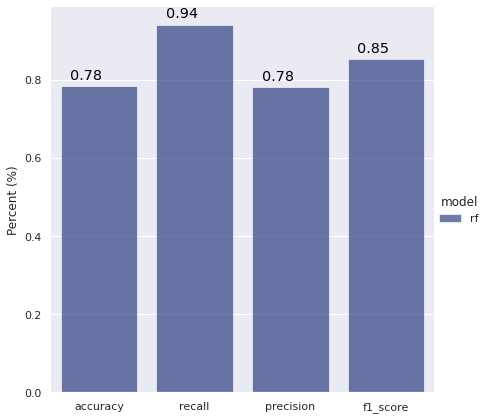

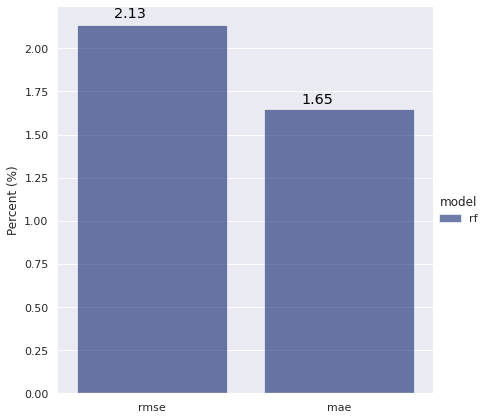

In [23]:
eval = evaluator()
features =  pd.read_pickle('/content/drive/My Drive/clothes_attr.pkl')
df = pd.DataFrame(columns=['user','metric','score'])
df2 = pd.DataFrame(columns=['user','metric','score'])
for u in range(1):
  #model = cb_rf(0,features)
  grade_df = rf.evaluate_system(all_train,all_test)
  a,b = eval.average_arpf_rm(data=grade_df,cols=columns,threshold=5,model='rf')
  df = df.append(a)
  df2 = df2.append(b)

eval.visualize_bars(df = df,axe_x='metric',axe_y='score',hue='model',title='model',x_dist=0.1,hei_=6,asp_=6/6)

eval.visualize_bars(df = df2,axe_x='metric',axe_y='score',hue='model',title='model',x_dist=0.2,hei_=6,asp_=6/6)

# **`cb_rf_cov_nov.py`**

[I 2021-01-09 10:37:40,286] A new study created in memory with name: no-name-34700512-57fc-4659-887a-186a6e089f7d
[I 2021-01-09 10:37:40,667] Trial 0 finished with value: 4.934772276406328 and parameters: {'n_estimators': 37, 'max_depth': 24.043296220270502}. Best is trial 0 with value: 4.934772276406328.
[I 2021-01-09 10:37:41,033] Trial 1 finished with value: 5.252765960313736 and parameters: {'n_estimators': 37, 'max_depth': 22.895593342274136}. Best is trial 0 with value: 4.934772276406328.
[I 2021-01-09 10:37:41,423] Trial 2 finished with value: 4.73514780832611 and parameters: {'n_estimators': 35, 'max_depth': 31.75342967017628}. Best is trial 2 with value: 4.73514780832611.
[I 2021-01-09 10:37:41,766] Trial 3 finished with value: 4.934676838793189 and parameters: {'n_estimators': 33, 'max_depth': 24.88478285302697}. Best is trial 2 with value: 4.73514780832611.
[I 2021-01-09 10:37:42,123] Trial 4 finished with value: 5.295557989937099 and parameters: {'n_estimators': 38, 'max_de

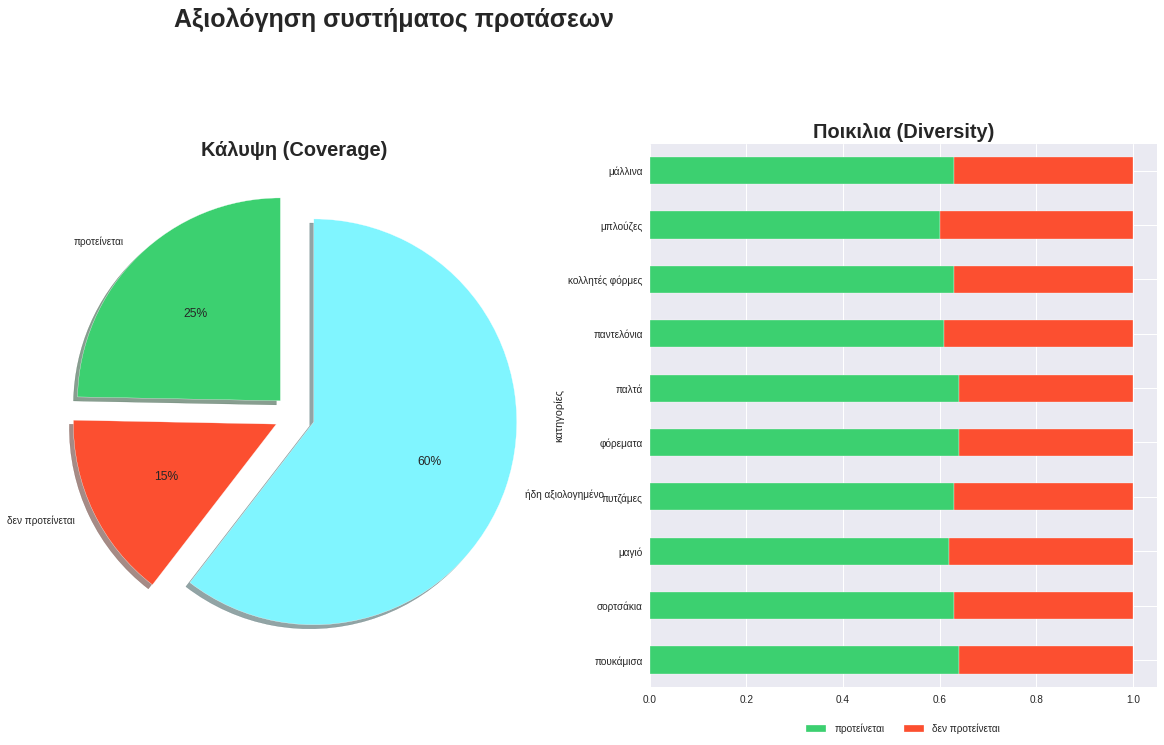

In [27]:
cat_ = pd.read_pickle('/content/drive/My Drive/id_category.pkl')
translator_ = pd.read_pickle('/content/drive/My Drive/cat_translator.pkl')
dffff = rf.coverage(6)
df2 = rf.novelty(cat_,6,translator_)
 
evaluator().visualize_pie(dffff,df2)